In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt


In [2]:
import numpy as np
import warnings
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv("/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt")

In [4]:
data.head()

,Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3
0,16/12/2006;17:24:00;4.216;0.418;234.840;18.400...
1,16/12/2006;17:25:00;5.360;0.436;233.630;23.000...
2,16/12/2006;17:26:00;5.374;0.498;233.290;23.000...
3,16/12/2006;17:27:00;5.388;0.502;233.740;23.000...
4,16/12/2006;17:28:00;3.666;0.528;235.680;15.800...


In [5]:
data = data['Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3'].str.split(';', expand=True)



In [6]:
data.columns = ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Date                   object
 1   Time                   object
 2   Global_active_power    object
 3   Global_reactive_power  object
 4   Voltage                object
 5   Global_intensity       object
 6   Sub_metering_1         object
 7   Sub_metering_2         object
 8   Sub_metering_3         object
dtypes: object(9)
memory usage: 142.5+ MB


In [8]:
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.000


In [9]:

print(data.columns)

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')


In [10]:

data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H:%M:%S')


In [11]:
data.set_index('DateTime', inplace=True)

In [12]:
data = data[['Global_active_power']]

In [13]:
print(data[['Global_active_power']])

                    Global_active_power
DateTime                               
2006-12-16 17:24:00               4.216
2006-12-16 17:25:00               5.360
2006-12-16 17:26:00               5.374
2006-12-16 17:27:00               5.388
2006-12-16 17:28:00               3.666
...                                 ...
2010-11-26 20:58:00               0.946
2010-11-26 20:59:00               0.944
2010-11-26 21:00:00               0.938
2010-11-26 21:01:00               0.934
2010-11-26 21:02:00               0.932

[2075259 rows x 1 columns]


In [14]:
data.dropna(inplace=True)

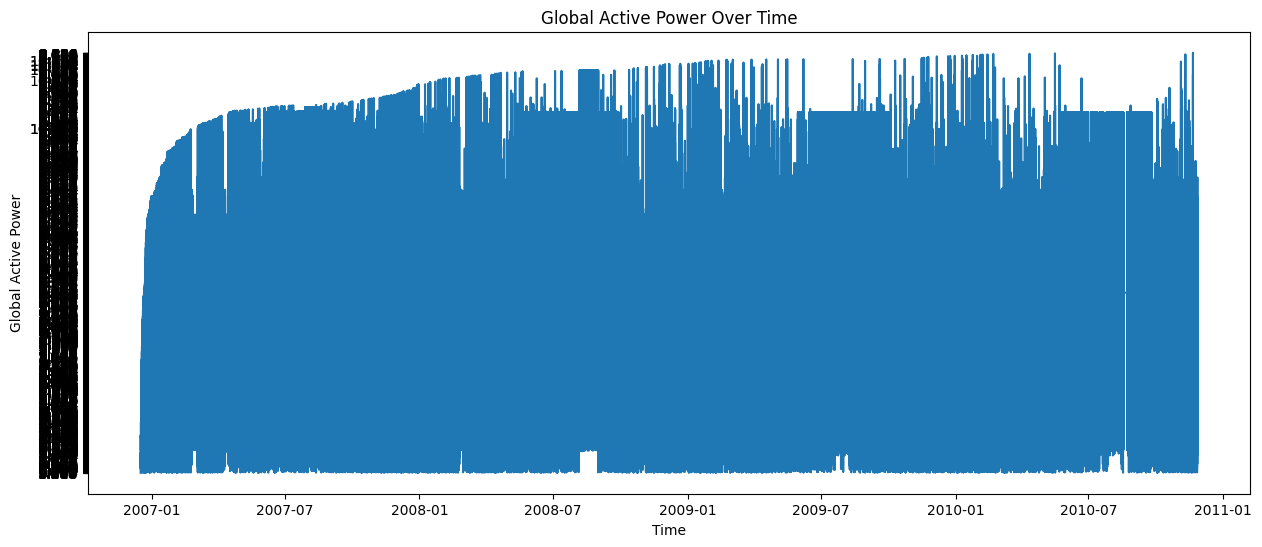

In [15]:
%matplotlib inline
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['Global_active_power'])
plt.title('Global Active Power Over Time')
plt.xlabel('Time')
plt.ylabel('Global Active Power')


plt.show()

In [16]:

data['Month'] = data.index.month
data['Day'] = data.index.day
data['Hour'] = data.index.hour


In [17]:
data.replace('?', np.nan, inplace=True)

In [18]:
warnings.filterwarnings("ignore", category=FutureWarning)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)


In [19]:

sequenceLength = 10 


X, y = [], []
for i in range(len(data_scaled) - sequenceLength):
    X.append(data_scaled[i:i+sequenceLength, 0])
    y.append(data_scaled[i+sequenceLength, 0])

X, y = np.array(X), np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [20]:

train_size = int(len(data_scaled) * 0.80)
train, test = data_scaled[0:train_size], data_scaled[train_size:]


In [21]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [22]:
epochs = 1
batch_size = 32  
model.fit(X, y, epochs=epochs, batch_size=batch_size)



64852/64852 [==============================] - 342s 5ms/step - loss: nan


In [23]:

test_inputs = data_scaled[len(data_scaled) - len(test) - sequenceLength:]
test_inputs = test_inputs.reshape(-1, 1)

X_test = []
for i in range(sequenceLength, len(test_inputs)):
    X_test.append(test_inputs[i-sequenceLength:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_values = model.predict(X_test)






51883/51883 [==============================] - 122s 2ms/step


In [24]:
predicted_values = predicted_values.reshape(-1,1) 

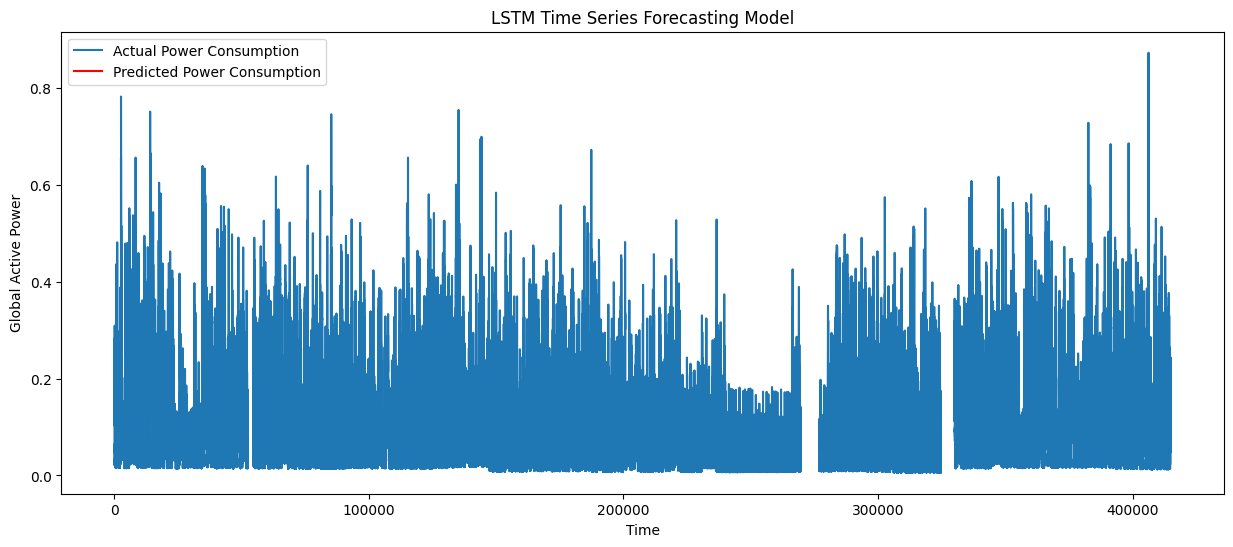

In [25]:
test_index = range(len(test))
length_common = min(len(test_index), len(test), len(predicted_values))

plt.figure(figsize=(15, 6))
plt.plot(test_index[:length_common], test[:length_common, 0], label='Actual Power Consumption')
plt.plot(test_index[:length_common], predicted_values[:length_common, 0], label='Predicted Power Consumption', color='red')
plt.title('LSTM Time Series Forecasting Model')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()